In [1]:
import os
import sys
sys.path.append("../")
import csv
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import settings

In [2]:
BLOOM_THRESHOLD = 15000
BLOOM_DATA_PATH = os.path.join(settings.final_data_path, "agua_open_data(1).csv")

In [3]:
ndci_data_path = os.path.join(settings.final_data_path, "kmeans_3", "ndci_data.csv")
precipitation_data_path = os.path.join(settings.final_data_path, "precipitation", "precipitation.csv")
wind_data_path = os.path.join(settings.final_data_path, "wind_data.csv")
water_temperature_data_path = os.path.join(settings.final_data_path, "water_temperature.csv")

### Dataset loading class

In [16]:
class PredictionDataset():
    def __init__(self, wind_data_path, water_temperature_data_path, precipitation_data_path, ndci_data_path):
        self.wind_data_path = wind_data_path
        self.water_temperature_data_path = water_temperature_data_path
        self.precipitation_data_path = precipitation_data_path
        self.ndci_data_path = ndci_data_path
        
        self.wind_data, self.temperature_data = self._load_wind()
        self.ndci_data = self._load_ndci()
        self.precipitation_data = self._load_precipitation()
        self.water_temperature_data = self._load_water_temperature()
        
    def _load_wind(self):
        wind_df = pd.read_csv(self.wind_data_path)
        numeric_columns = ['wind_00', 'wind_06', 'wind_12', 'wind_18', 'temp_00', 'temp_06', 'temp_12', 'temp_18']
        wind_df['date']= pd.to_datetime(wind_df['date'], dayfirst=True)
        for c in numeric_columns:
            wind_df[c] = pd.to_numeric(wind_df[c])
        
        temp_df = wind_df[['date', 'temp_00', 'temp_06', 'temp_12', 'temp_18']].copy()
        del wind_df['temp_00']
        del wind_df['temp_06']
        del wind_df['temp_12']
        del wind_df['temp_18']
        
        temp_df['temperature'] = temp_df[['temp_06', 'temp_12']].mean(axis=1)
        del temp_df["temp_00"]
        del temp_df["temp_06"]
        del temp_df["temp_12"]
        del temp_df["temp_18"]
        
        wind_df['wind'] = wind_df[['wind_06', 'wind_12']].mean(axis=1)
        del wind_df["wind_00"]
        del wind_df["wind_06"]
        del wind_df["wind_12"]
        del wind_df["wind_18"]
        return wind_df, temp_df
    
    def _load_ndci(self):
        ndci_df = pd.read_csv(self.ndci_data_path)
        ndci_df['date']= pd.to_datetime(ndci_df['date'])
        
        unique_dates = ndci_df['date'].unique()
        unique_clusters = ndci_df['cluster'].unique()
        ndci_types = ["mean", "min", "max"]
        clusters_columns = [f"cluster{c}_{nt}" for c in unique_clusters for nt in ndci_types]
        ndci_columns = clusters_columns.insert(0,"date")
        
        output = []
        for d in unique_dates:
            row = {}
            row['date'] = d
            date_ndci = ndci_df[ndci_df['date'] == d]
            for ci in unique_clusters:
                cluster_ndci = date_ndci[date_ndci["cluster"] == ci]
                row[f"cluster{ci}_mean"] = cluster_ndci.mean_ndci.tolist()[0]
                row[f"cluster{ci}_min"] = cluster_ndci.min_ndci.tolist()[0]
                row[f"cluster{ci}_max"] = cluster_ndci.max_ndci.tolist()[0]
            output.append(row)
        output_df = pd.DataFrame(output)
        return output_df
    
    def _load_precipitation(self):
        precipitation_df = pd.read_csv(self.precipitation_data_path)
        precipitation_df['date']= pd.to_datetime(precipitation_df['date'])
        return precipitation_df
    
    def _load_water_temperature(self):
        water_temperature_df = pd.read_csv(self.water_temperature_data_path)
        water_temperature_df['date']= pd.to_datetime(water_temperature_df['date'])
        #return water_temperature_df
        rows_to_remove = []
        for i in range(water_temperature_df.shape[0]):
            row_hour = water_temperature_df.iloc[i].date.hour
            if row_hour > 17 or (row_hour >= 0 and  row_hour <= 9):
                rows_to_remove.append(i)
        water_temperature_df = water_temperature_df.drop(rows_to_remove)
        water_temperature_df['date'] = water_temperature_df['date'].dt.strftime('%Y-%m-%d')
        water_temperature_df = water_temperature_df.groupby('date', as_index=False).mean()
        water_temperature_df['date']= pd.to_datetime(water_temperature_df['date'])
        return water_temperature_df
    
    
    def get_historic_data(self, date, days=3):        
        ndci = self.ndci_data[(self.ndci_data['date'] >= date - timedelta(days=days)) & (self.ndci_data['date'] <= date)]
        wind = self.wind_data[(self.wind_data['date'] >= date - timedelta(days=days)) & (self.wind_data['date'] <= date)]
        temperature = self.temperature_data[(self.temperature_data['date'] >= date - timedelta(days=days)) & (self.temperature_data['date'] <= date)]
        precipitation = self.precipitation_data[(self.precipitation_data['date'] >= date - timedelta(days=days)) & (self.precipitation_data['date'] <= date)]
        water_temperature = self.water_temperature_data[(self.water_temperature_data['date'] >= date - timedelta(days=days)) & (self.water_temperature_data['date'] <= date)]
        
        all_historic_data = {"ndci": ndci, "wind": wind, "temperature":temperature,
                             "precipitation": precipitation, "water_temperature": water_temperature}
        
        output = []
        for d in range(days):
            row = {}
            dt = date - timedelta(days=d)
            row["date"] = dt
            for df in all_historic_data.values():
                day_data = df[df["date"] == dt].to_dict("records")
                cols = df.columns.tolist()
                cols.remove("date")
                for col in cols:
                    if day_data == []:
                        row[col] = np.nan
                    else:
                        row[col] = day_data[0][col]
            output.append(row)
        return pd.DataFrame(output)

dataset = PredictionDataset(wind_data_path, water_temperature_data_path, precipitation_data_path, ndci_data_path)

In [17]:
sample_date = datetime(2019, 2, 10)
dataset.get_historic_data(sample_date, days=10)

,date,cluster0_mean,cluster0_min,cluster0_max,cluster1_mean,cluster1_min,cluster1_max,cluster2_mean,cluster2_min,cluster2_max,wind,temperature,precipitation,water_temperature
0,2019-02-10,-0.046916,-0.079332,-0.014501,-0.045083,-0.076735,-0.013431,-0.046591,-0.077084,-0.016097,5.5,27.0,0.00,27.223790
1,2019-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,26.0,11.66,NaN
2,2019-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,25.0,0.32,NaN
3,2019-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,23.5,0.00,NaN
4,2019-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,22.0,0.00,NaN
5,2019-02-05,-0.014706,-0.043259,0.013847,-0.022396,-0.055792,0.010999,-0.013708,-0.043395,0.015979,4.0,20.5,0.00,26.733347
6,2019-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,19.0,0.00,NaN
7,2019-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,19.5,0.00,NaN
8,2019-02-02,0.023213,-0.025759,0.072184,-0.020751,-0.069121,0.027618,0.029605,-0.018526,0.077735,15.0,22.5,1.05,26.711870
9,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,25.0,1.97,NaN


In [5]:
dataset.wind_data

,date,wind
0,2017-11-01,5.5
1,2017-11-02,16.0
2,2017-11-03,15.0
3,2017-11-04,8.0
4,2017-11-05,3.0
...,...,...
1633,2022-04-26,10.5
1634,2022-04-27,16.5
1635,2022-04-28,8.5
1636,2022-04-29,11.0


In [74]:
dataset.temperature_data

,date,temperature
0,2017-11-01,15.5
1,2017-11-02,18.0
2,2017-11-03,19.0
3,2017-11-04,17.5
4,2017-11-05,16.0
...,...,...
1633,2022-04-26,20.0
1634,2022-04-27,20.0
1635,2022-04-28,16.5
1636,2022-04-29,13.0


In [76]:
dataset.ndci_data

,date,cluster0_mean,cluster0_min,cluster0_max,cluster1_mean,cluster1_min,cluster1_max,cluster2_mean,cluster2_min,cluster2_max
0,2017-11-19,-0.013329,-0.036938,0.010280,-0.003239,-0.041439,0.034961,-0.013042,-0.039807,0.013722
1,2017-11-29,0.026099,-0.088685,0.140883,0.008282,-0.094014,0.110579,0.015490,-0.090686,0.121665
2,2017-12-12,-0.013108,-0.032083,0.005866,-0.016957,-0.037061,0.003147,-0.012784,-0.034570,0.009001
3,2017-12-29,0.458423,0.269749,0.647096,0.078396,-0.131314,0.288105,0.131697,-0.076435,0.339828
4,2018-01-08,-0.036806,-0.068410,-0.005202,-0.039759,-0.077978,-0.001540,-0.041512,-0.083088,0.000064
...,...,...,...,...,...,...,...,...,...,...
76,2021-02-24,-0.021266,-0.042258,-0.000273,-0.025105,-0.044864,-0.005345,-0.017890,-0.040418,0.004638
77,2021-02-26,0.003060,-0.034349,0.040470,-0.016479,-0.041159,0.008201,0.006880,-0.036052,0.049813
78,2021-03-28,-0.013467,-0.058998,0.032063,-0.023762,-0.050083,0.002560,-0.009045,-0.063942,0.045852
79,2021-04-07,-0.029022,-0.054393,-0.003650,-0.028113,-0.052215,-0.004012,-0.026249,-0.054235,0.001736


In [78]:
dataset.precipitation_data

,precipitation,date
0,58.430000,2016-11-01
1,0.220000,2016-11-02
2,0.000000,2016-11-03
3,0.000000,2016-11-04
4,0.000000,2016-11-05
...,...,...
1975,3.940000,2022-04-22
1976,0.000000,2022-04-23
1977,0.000000,2022-04-24
1978,62.790001,2022-04-25


In [80]:
dataset.water_temperature_data

,date,water_temperature
0,2017-11-19,17.317070
1,2017-11-29,21.506166
2,2017-12-12,24.530767
3,2018-01-08,29.250406
4,2018-01-11,29.555037
...,...,...
88,2022-03-03,23.426823
89,2022-03-11,22.533678
90,2022-03-16,23.757390
91,2022-04-02,18.746542


### LST water temperature correlation with Windguru temperature

In [70]:
merged_temp_df = pd.merge(dataset.water_temperature_data, dataset.temperature_data, on="date", how="left")
merged_temp_df

,date,water_temperature,temperature
0,2017-11-19,17.317070,16.0
1,2017-11-29,21.506166,17.0
2,2017-12-12,24.530767,19.0
3,2018-01-08,29.250406,24.0
4,2018-01-11,29.555037,26.5
...,...,...,...
88,2022-03-03,23.426823,19.0
89,2022-03-11,22.533678,19.0
90,2022-03-16,23.757390,22.0
91,2022-04-02,18.746542,15.5


In [69]:
print(merged_temp_df['temperature'].corr(merged_temp_df['water_temperature']))

0.7692655411915296


### Load and visualize GT 

          date  cyanobacteria
0   2020-01-02        1150.00
1   2020-01-04       20731.00
2   2020-01-05       17521.00
3   2020-01-06        9943.00
4   2020-01-07       10401.00
..         ...            ...
162 2020-10-31        1083.00
163 2020-11-01          47.00
164 2020-11-02           5.96
165 2020-11-05           9.06
166 2021-02-04           1.77

[167 rows x 2 columns]


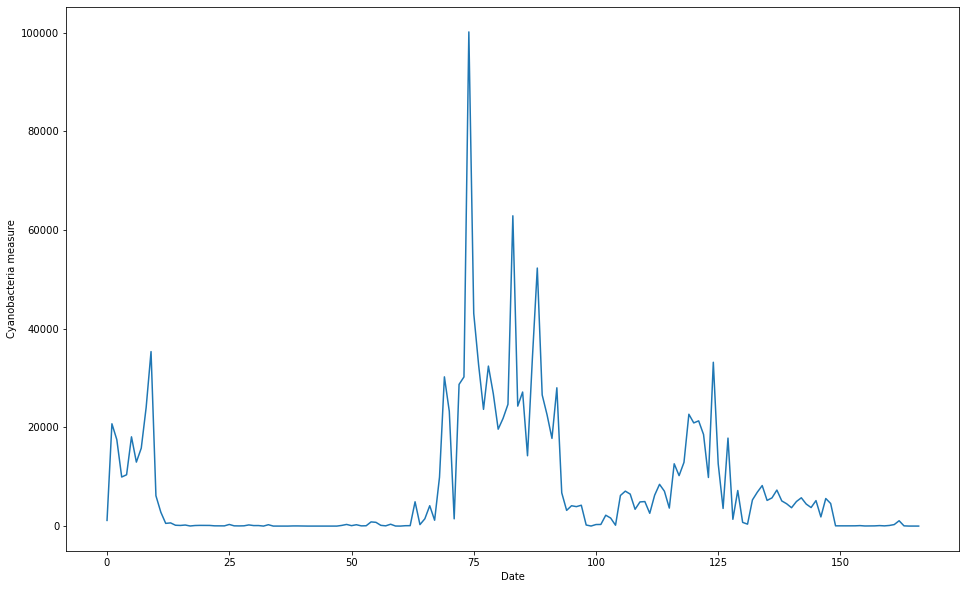

In [30]:
def load_cyano_concentration_csv(csv_path):
    agua_data = []
    with open(csv_path, newline='\n') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for i, row in enumerate(spamreader):
            day_measure = {} 
            if i==0:
                continue
            date_time = datetime.strptime(row[0][0:10], "%Y-%m-%d")
            day_measure["date"] = date_time
            
            cyano_value = row[2]
            day_measure["cyanobacteria"] = float(cyano_value)
            agua_data.append(day_measure)
    #output = pd.DataFrame(agua_data)
    return agua_data

agua_data = load_cyano_concentration_csv(BLOOM_DATA_PATH)
print(pd.DataFrame(agua_data))
plt.figure(figsize=(16,10))
plt.plot(pd.DataFrame(agua_data)["cyanobacteria"])
plt.xlabel('Date')
plt.ylabel('Cyanobacteria measure')
plt.show()

### Make column "Days before bloom"

In [31]:
for i, day_data in enumerate(agua_data):
    day_date = day_data["date"]
    day_cyano = day_data["cyanobacteria"]
    if day_cyano >= BLOOM_THRESHOLD:
        day_data["label"] = "In bloom"
    else:
        try:
            if agua_data[i+1]["cyanobacteria"] >= BLOOM_THRESHOLD:
                day_data["label"] = str((agua_data[i+1]["date"] - day_date).days) + " days before bloom"
            elif agua_data[i+2]["cyanobacteria"] >= BLOOM_THRESHOLD:
                day_data["label"] = str((agua_data[i+2]["date"] - day_date).days) + " days before bloom"
            elif agua_data[i+3]["cyanobacteria"] >= BLOOM_THRESHOLD:
                day_data["label"] = str((agua_data[i+3]["date"] - day_date).days) + " days before bloom"
            else:
                day_data["label"] = "Far from bloom"
        except IndexError:
            day_data["label"] = "Far from bloom"

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(pd.DataFrame(agua_data))       

          date  cyanobacteria                label
0   2020-01-02       1150.000  2 days before bloom
1   2020-01-04      20731.000             In bloom
2   2020-01-05      17521.000             In bloom
3   2020-01-06       9943.000  2 days before bloom
4   2020-01-07      10401.000  1 days before bloom
5   2020-01-08      18087.000             In bloom
6   2020-01-09      12964.000  1 days before bloom
7   2020-01-10      15791.000             In bloom
8   2020-01-11      24033.000             In bloom
9   2020-01-12      35358.000             In bloom
10  2020-01-13       6152.000       Far from bloom
11  2020-01-14       2822.000       Far from bloom
12  2020-01-15        550.000       Far from bloom
13  2020-01-16        647.000       Far from bloom
14  2020-01-17        173.000       Far from bloom
15  2020-01-18        131.000       Far from bloom
16  2020-01-19        215.000       Far from bloom
17  2020-01-20         21.200       Far from bloom
18  2020-01-21        118.000  